<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/msch_kNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extended Project 1: $k$-Nearest Neighbours and Support Vector Machines**

---



Course: Computation Machine Learning II

Submission Date: Feb 20, 2022

Student: Mathias Schindler

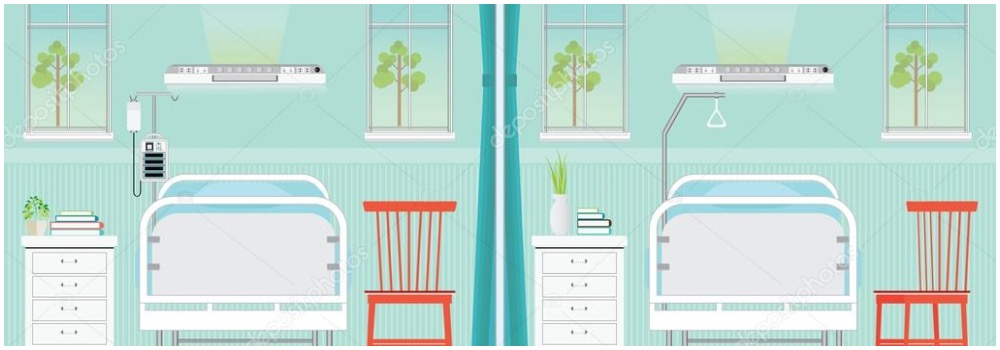

## Instructions

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# **0. Preamble**

In [ ]:
# clear everything
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', '_sh', 'exit', 'get_ipython', 'quit']


In [ ]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2/Project1 - kNN, SVM')

In [ ]:
!ls

'Copy of Copy of Copy of msch_kNN_v1.ipynb'   msch_kNN_v1.ipynb
 data					      preds
 extra_data				      __pycache__
 mschindler_functions_v3.py


In [ ]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler 

In [ ]:
# Import custom functions
import mschindler_functions_v3 as my_fcts
dir(my_fcts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'construct_age_admit',
 'datetime',
 'make_feat_importance_plot',
 'make_multi_point_pred',
 'make_nan_fig',
 'make_roc_plot',
 'make_scree_plot',
 'np',
 'pd',
 'plot_confusion_matrix',
 'plt',
 'reweight',
 'reweight_proba_multi',
 'sns',
 'timedelta']

# **1. Exploratory Data Analysis**

## 1.1 Load Data

In [ ]:
# Load data
df_train = pd.read_csv("data/mimic_train.csv", index_col=3)
df_test = pd.read_csv("data/mimic_test_death.csv", index_col=2)

In [ ]:
# Remove identifier variables
id_vars = ['subject_id', 'hadm_id']

df_train = df_train.drop(id_vars, axis = 1)
df_test = df_test.drop(id_vars, axis = 1)

## 1.2 Data Types

In [ ]:
# Check data types in datasets
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
DOD                      object
ADMITTIME                object
DISCHTIME                object
DEATHTIME                object
Diff    

Variables `GENDER`, `DOB`, `ADMITTIME`, `ADMISSION_TYPE`, `INSURANCE`, `RELIGION`, `MARITAL_STATUS`, `ETHNICITY`, `DIAGNOSIS`, `ICD9_diagnosis`, `FIRST_CAREUNIT` are string.


## 1.3 Missing Data Exploration

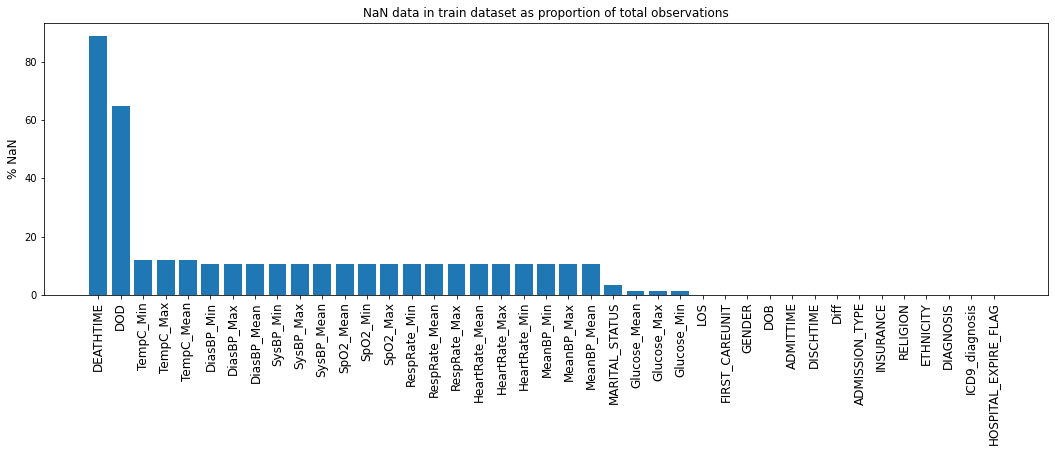

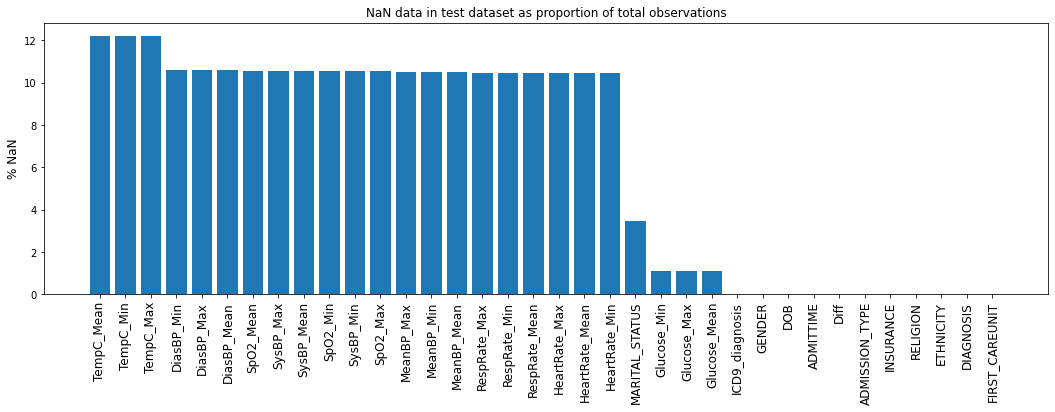

<BarContainer object of 36 artists>

In [ ]:
# Investigate missing data
my_fcts.make_nan_fig(df_train, 'train')
my_fcts.make_nan_fig(df_test, 'test')

## 1.4 Feature Distribution

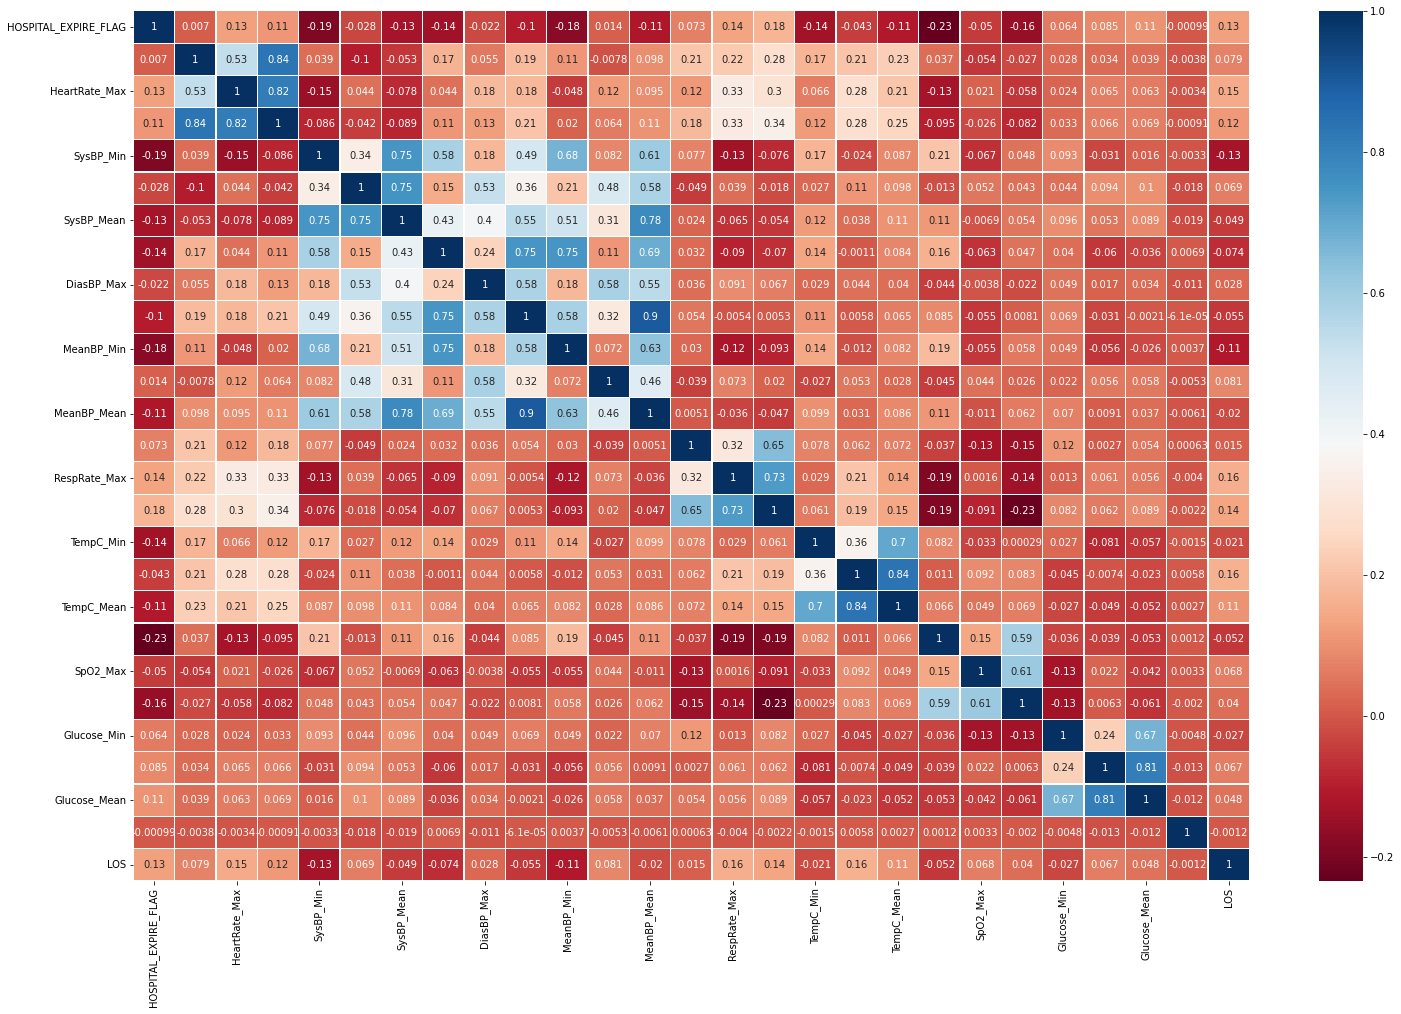

In [ ]:
# plot a heatmap
colormap = plt.cm.RdBu

sns.heatmap(df_train.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)
fig = plt.gcf()
fig.set_size_inches(25, 16)

In [ ]:
%%script false
sns.histplot(df_train)

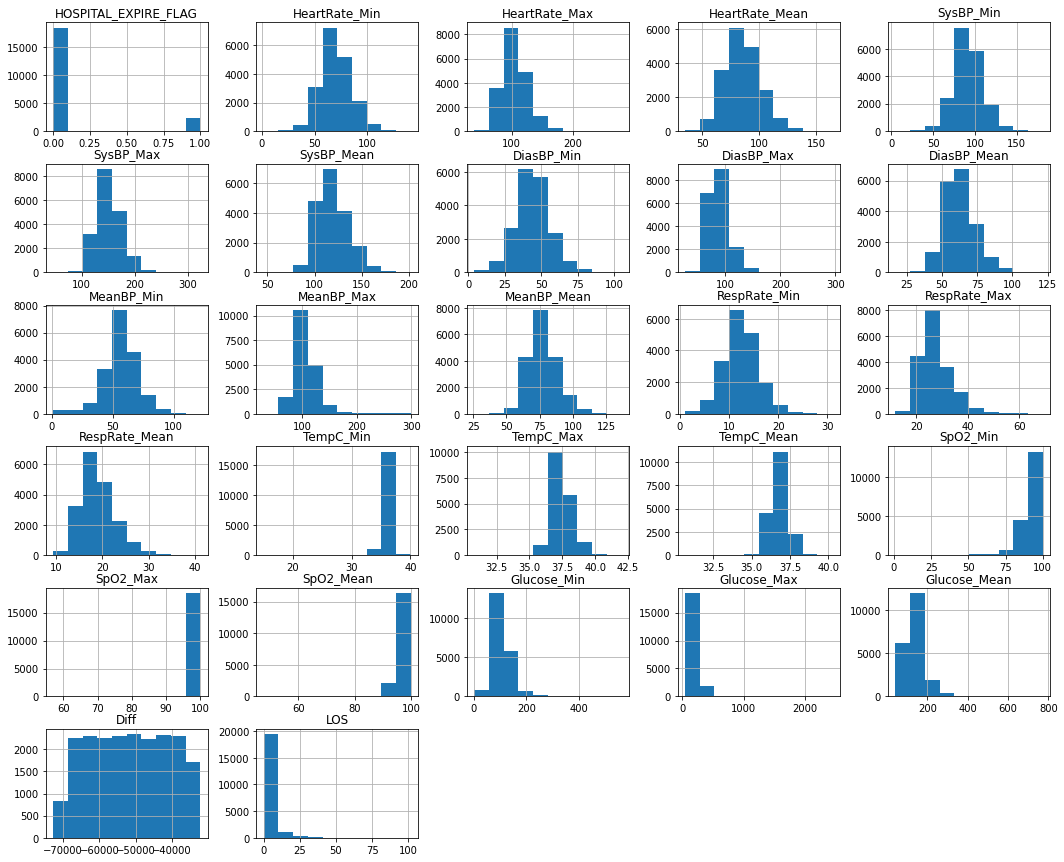

In [ ]:
# Plot each covariate distribution
df_train.hist()
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.show()

# **2. Feature Engineering**

## 2.1 Age-at-Admission Variable

### 2.1.1 Format Age Variables using `datetime`

Format admission datetime (see custom functions in external .py-file with custom functions).

In [ ]:
df_train_age = my_fcts.construct_age_admit(df_train)
df_test_age = my_fcts.construct_age_admit(df_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### 2.1.2 Inspect Constructed Age Variables

In [ ]:
# Check if missing values were generated
print(df_train_age['age_at_admin'].isnull().any() )
print(df_test_age['age_at_admin'].isnull().any() )

False
False


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


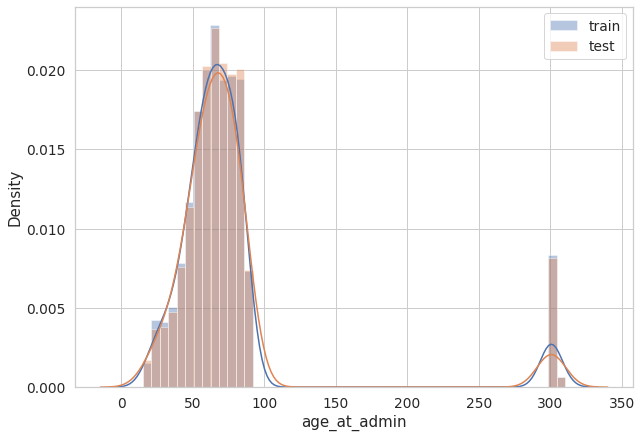

In [ ]:
# Check distribution

# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train')
sns.distplot(df_test_age['age_at_admin'], label='test')

# Add legend
plt.legend()

In [ ]:
#Counts of >100-year-olds 
print("No. of individuals in train more than 100 years old: " + str(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in train for those >100 years:")
print(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

print("\n")

print("No. of individuals in test more than 100 years old: " + str(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in test for those >100 years:")
print(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

No. of individuals in train more than 100 years old: 1107

 Value counts in train for those >100 years:
299.994524    795
300.054757      4
306.877481      3
300.021903      3
300.027379      3
             ... 
305.733060      1
304.290212      1
303.085558      1
302.291581      1
303.498973      1
Name: age_at_admin, Length: 270, dtype: int64


No. of individuals in test more than 100 years old: 270

 Value counts in test for those >100 years:
299.994524    201
304.859685      2
300.027379      2
302.297057      1
300.202601      1
             ... 
301.642710      1
303.181383      1
300.711841      1
300.257358      1
303.241615      1
Name: age_at_admin, Length: 68, dtype: int64


So, those individuals over 100 years old are calculated to be between 299 to 303 years old. Seems quite unrealistic. In order to not delete observations (and for a lack of better alternative) these values are replaced by the median.

### 2.1.3 Clean Constructed Age Variables



---


**NOTE TO SELF:** Revisit this imputation with fancier methods and making sure that no information from train ''spills over'' to test data. 
<br>
Maybe use clustering to impute age from individuals with similar conditions. Prob older people show different characteristics than younger people -> problematic imputing median for all. Co-morbidity info would prob help here.

---



In [ ]:
# Train
median_age_train = df_train_age.loc[df_train_age['age_at_admin']<100, 'age_at_admin'].median()
# Set >100 year-olds to missing for var 'age_at_admin'
df_train_age.loc[df_train_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_train_age['age_at_admin'].fillna(median_age_train, inplace=True)

# Test
#median_test = df_test_age.loc[df_test_age['age_at_admin']<100, 'age_at_admin'].median()
df_test_age.loc[df_test_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_test_age['age_at_admin'].fillna(median_age_train, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


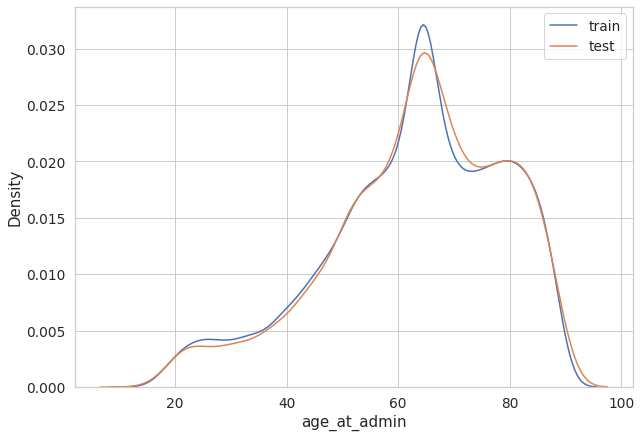

In [ ]:
# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train', hist = False)
sns.distplot(df_test_age['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()

## 2.2 Co-Morbitidity Index

## 2.3 Missing Data Imputation



---


**NOTE TO SELF:** Preliminary imputation. Use fancier methods for final submission. 
<br>
Deal with missing string variables `DOD`, `DEATHTIME` and `MARITAL_STATUS`

---



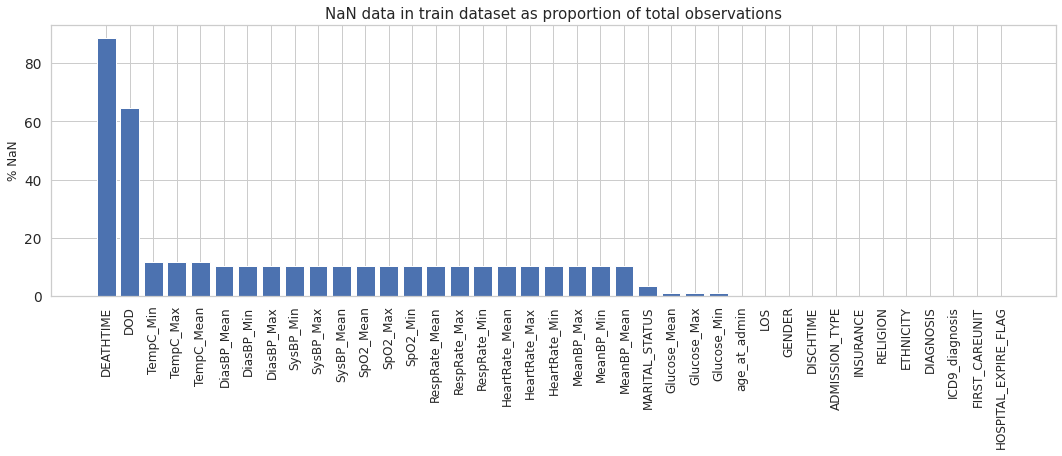

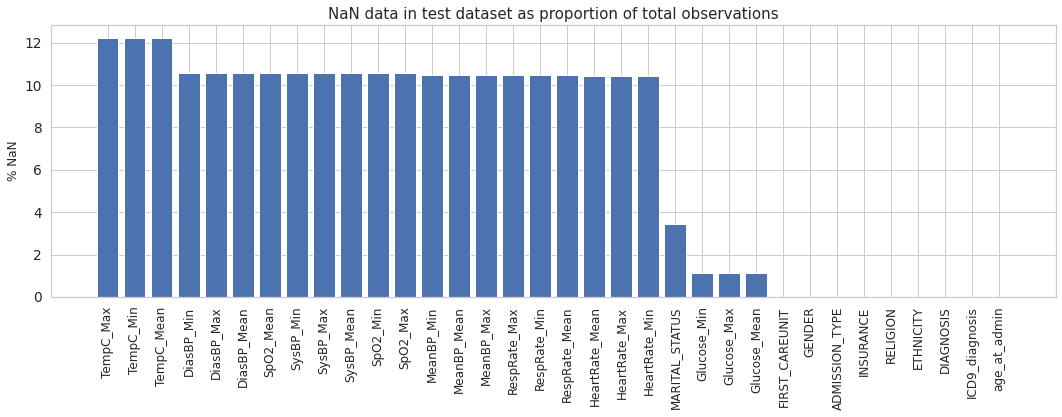

<BarContainer object of 34 artists>

In [ ]:
# Investigate missing data
my_fcts.make_nan_fig(df_train_age, 'train')
my_fcts.make_nan_fig(df_test_age, 'test')

In [ ]:
# Save list of features w NA for train and test

na_cols_train = df_train_age.columns[df_train_age.isnull().any()].to_list()
na_cols_test = df_test_age.columns[df_test_age.isnull().any()].to_list()

In [ ]:
# Which NA-cols in train but not test
print(list(set(na_cols_train) - set(na_cols_test)) )
print(list(set(na_cols_test) - set(na_cols_train)) )

['DEATHTIME', 'DOD']
[]


In [ ]:
%%script false

# The following are string and hence cannot be computed means
print(na_cols_train[24:27])

df_train_test['DOD'].mean()
df_train_test['DEATHTIME'].mean()
df_train_test['MARITAL_STATUS'].mean()

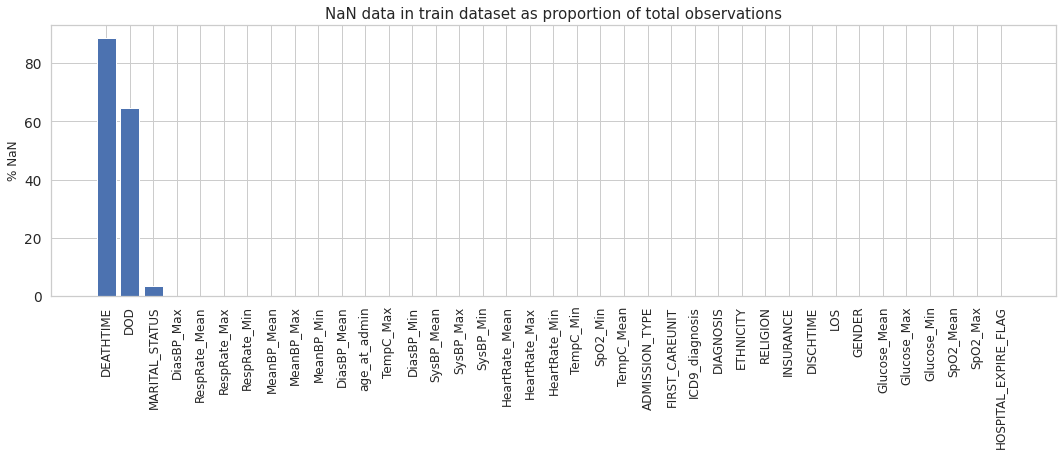

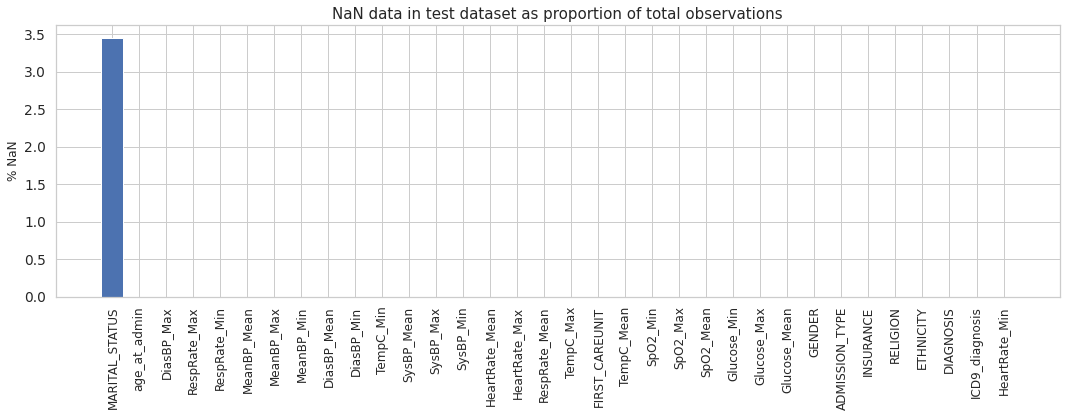

<BarContainer object of 34 artists>

In [ ]:
#Make copies
df_train_fillna = df_train_age.copy()
df_test_fillna = df_test_age.copy()


# Loop over all non-string columns
for k in range(len(na_cols_train[:24])):
  # Calculate mean for given columns
  mean_train = df_train_fillna[na_cols_train[k]].mean()
  
  # Fill NA w. mean for given column (train)
  df_train_fillna[na_cols_train[k]].fillna(mean_train, inplace = True)
  
  # Fill NA w. mean for given column (test w train-mean)
  df_test_fillna[na_cols_train[k]].fillna(mean_train, inplace = True)


# Investigate missing data
my_fcts.make_nan_fig(df_train_fillna, 'train')
my_fcts.make_nan_fig(df_test_fillna, 'test')

### 2.3.1 (Very!) Preliminary Imputation of String NA-Cols

In [ ]:
# Drop 'DEATHTIME' and 'DOD' from train data
df_train_fillna = df_train_fillna.drop(['DEATHTIME', 'DOD'], axis = 1)

In [ ]:
# Fill 'MARITAL_STATUS' w. most frequent observation
most_freq_train = df_train_fillna['MARITAL_STATUS'].value_counts().index[0]

df_train_fillna['MARITAL_STATUS'] = df_train_fillna['MARITAL_STATUS'].fillna(most_freq_train)
df_test_fillna['MARITAL_STATUS'] = df_test_fillna['MARITAL_STATUS'].fillna(most_freq_train)

In [ ]:
# Investigate missing data
print(df_train_fillna.isna().any() )
print(df_test_fillna.isna().any() )

HOSPITAL_EXPIRE_FLAG    False
HeartRate_Min           False
HeartRate_Max           False
HeartRate_Mean          False
SysBP_Min               False
SysBP_Max               False
SysBP_Mean              False
DiasBP_Min              False
DiasBP_Max              False
DiasBP_Mean             False
MeanBP_Min              False
MeanBP_Max              False
MeanBP_Mean             False
RespRate_Min            False
RespRate_Max            False
RespRate_Mean           False
TempC_Min               False
TempC_Max               False
TempC_Mean              False
SpO2_Min                False
SpO2_Max                False
SpO2_Mean               False
Glucose_Min             False
Glucose_Max             False
Glucose_Mean            False
GENDER                  False
DISCHTIME               False
ADMISSION_TYPE          False
INSURANCE               False
RELIGION                False
MARITAL_STATUS          False
ETHNICITY               False
DIAGNOSIS               False
ICD9_diagn

# **3. Preprocessing Data**

Compare features in both data sets

In [ ]:
print("Features in train data but not in test:")
print(df_train_fillna.columns.difference(df_test_fillna.columns) )

print("\n Features in test data but not in train:")
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Features in train data but not in test:
Index(['DISCHTIME', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')

 Features in test data but not in train:
Index([], dtype='object')


In [ ]:
# Remove features in train that are not in test (except target 'HOSPITAL_EXPIRE_FLAG')
df_train_fillna = df_train_fillna.drop(['DISCHTIME', 'LOS'], axis = 1)

In [ ]:
print(df_train_fillna.columns.difference(df_test_fillna.columns) )
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Index(['HOSPITAL_EXPIRE_FLAG'], dtype='object')
Index([], dtype='object')


## 3.0 Split Categorical and Numerical Data

In [ ]:
# Numerical Data
cat_feats = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", 
             "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]

df_train_num = df_train_fillna.drop(cat_feats, axis = 1)
df_test_num = df_test_fillna.drop(cat_feats, axis = 1)

In [ ]:
# Categorical Data
df_train_cat = df_train_fillna[cat_feats]
df_test_cat = df_test_fillna[cat_feats]

In [ ]:
# Split target
y_train = df_train_fillna['HOSPITAL_EXPIRE_FLAG']
df_train_num = df_train_num.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)

Temporary: Compare again

In [ ]:
# Compare numerical features
print(df_train_num.columns.difference(df_test_num.columns) )
print(df_test_num.columns.difference(df_train_num.columns) )

Index([], dtype='object')
Index([], dtype='object')


In [ ]:
# Compare categorical features
print(df_train_cat.columns.difference(df_test_cat.columns) )
print(df_test_cat.columns.difference(df_train_cat.columns) )

Index([], dtype='object')
Index([], dtype='object')


## 3.1 Numerical Features 

### 3.1.1 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [ ]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to data
scaler.fit(df_train_num)

# Transform data
df_train_scl = scaler.transform(df_train_num)
df_test_scl = scaler.transform(df_test_num)

# Format data
df_train_scl = pd.DataFrame(df_train_scl, columns = df_train_num.columns, index = df_train_num.index)
df_test_scl = pd.DataFrame(df_test_scl, columns = df_test_num.columns, index = df_test_num.index)

## 3.2 Categorical Features

### 3.2.1 One-Hot Encoding

Inspecting for which features it would be feasible to construct dummy variables.<br>
Features `GENDER`, `ADMISSION_TYPE`, `INSURANCE`, `MARITAL_STATUS` and `FIRST_CAREUNIT` are chosen for one-hot encoding. These seem relevant for the later task of predicting mortality, while having a not-too-large number of categories (so dimensionality does not explode).



---


**NOTE TO SELF:** Also try one-hotting everything and then dimensionality-reducing with PCA and/or SVD

---



In [ ]:
for c in cat_feats:
  print(c)
  print(df_train_cat[c].value_counts() )
  print("\n\n")

GENDER
M    11759
F     9126
Name: GENDER, dtype: int64



ADMISSION_TYPE
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: ADMISSION_TYPE, dtype: int64



INSURANCE
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: INSURANCE, dtype: int64



RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64



MARITAL_STATUS
MARRIED              10386
SINGLE                5910
WIDOWED               2819
DIVORCED              14

In [ ]:
# One-Hot Encoding
one_hot_feats = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'FIRST_CAREUNIT']
prfx_dict = {'GENDER': 'gender', 'ADMISSION_TYPE': 'admin_type', 'INSURANCE': 'ins', 'MARITAL_STATUS': 'mar_stat','FIRST_CAREUNIT': 'firstcare'}

df_train_dumm = pd.get_dummies(df_train_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)
df_test_dumm = pd.get_dummies(df_test_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)

In [ ]:
# Drop non-one-hot encoded features
drop_cat_feats = [ "RELIGION", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis"]

df_train_dumm = df_train_dumm.drop(drop_cat_feats, axis = 1)
df_test_dumm = df_test_dumm.drop(drop_cat_feats, axis = 1)

## 3.3 Concatenate Numerical and Categorical Features

In [ ]:
X_train = pd.concat([df_train_scl, df_train_dumm], axis = 1)
X_test = pd.concat([df_test_scl, df_test_dumm], axis = 1)

In [ ]:
print("Shape: " + str(X_train.shape))
X_train

Shape: (20885, 42)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
228357,1.371353e+00,2.008463,2.474416e+00,-1.032036e+00,-1.052701e+00,-7.951633e-01,-0.206698,0.089886,-1.284776e-01,1.993805e-01,-5.008976e-01,-2.915794e-01,0.911554,3.736866e-01,9.230392e-01,-1.368516e+00,-6.453202e-01,-1.185847e+00,-0.143967,-5.067807e-01,-5.109988e-01,0.120638,0.519763,0.490860,0.420258,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
221004,-4.766311e-01,0.240459,-4.182947e-01,-1.273002e-01,-1.318917e+00,-7.858952e-01,0.414856,-0.787468,2.133819e-01,1.257251e-01,-8.840143e-01,-2.671844e-01,0.319788,-1.141409e+00,-8.036251e-01,4.106957e-01,-1.089446e+00,-4.936007e-01,0.999204,4.048877e-01,9.934597e-01,-0.108167,-0.859167,-0.802892,-1.297563,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
296315,8.027428e-01,-0.365714,4.491223e-01,-1.876159e-01,-5.646396e-01,-4.026771e-01,0.059682,-1.171310,-5.465059e-01,5.676576e-01,-7.307676e-01,-4.489295e-01,0.319788,-1.141409e+00,-8.472305e-01,5.724422e-01,-7.193412e-01,-1.502029e-01,1.284997,4.048877e-01,1.419993e+00,0.721252,1.779258,1.764030,0.332998,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
245557,4.473612e-01,1.149718,9.436496e-01,-4.288789e-01,-6.977473e-01,-7.707219e-01,-1.272218,0.035051,-1.982988e+00,-6.108291e-01,-5.008976e-01,-1.409916e+00,0.023905,1.215407e+00,2.137552e+00,4.106957e-01,2.759647e+00,1.910184e+00,-1.858724,4.048877e-01,-8.071218e-01,0.034836,-0.468289,-0.310271,0.754583,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
225281,-1.010055e-15,0.000000,-1.960981e-14,-8.571382e-16,-1.261050e-15,1.259702e-14,0.000000,0.000000,3.480397e-14,5.233532e-16,-5.444416e-16,-3.378601e-14,0.000000,-5.980781e-16,4.877040e-15,4.033966e-13,-5.680271e-14,-1.756791e-13,0.000000,1.295559e-14,3.220123e-14,-0.279771,-0.490005,-0.578974,1.033301,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244530,-3.344784e-01,-0.668801,-4.609099e-01,-1.876457e+00,4.114840e-01,-5.172506e-01,-0.917045,0.309224,-5.682301e-01,-1.126417e+00,-1.944042e-01,-7.915883e-01,-0.567861,-8.047215e-01,-9.790159e-01,-7.215300e-01,-1.089446e+00,-1.052849e+00,0.856307,4.048877e-01,1.344461e+00,-1.109190,-0.468289,-0.790097,1.541461,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
216116,3.052085e-01,0.341488,2.743277e-01,5.361729e-01,-3.220851e-02,2.613282e-01,1.213996,-0.293957,5.096619e-01,1.304212e+00,-3.093392e-01,4.521110e-01,-0.863744,-6.363774e-01,-1.154387e+00,1.462048e+00,4.649952e-01,1.279453e+00,0.570515,4.048877e-01,3.011755e-01,2.208486,2.115848,2.385709,0.188763,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
274507,-8.320127e-01,-0.416229,-5.690034e-01,1.742785e-01,-8.752244e-01,-4.500810e-01,0.947616,-0.293957,4.666525e-01,7.149684e-01,-4.625859e-01,8.468245e-02,0.615671,-1.313454e-01,-2.249105e-01,6.329384e-03,-2.011940e-01,4.524952e-01,0.856307,4.048877e-01,1.057440e+00,-1.595401,3.017038,1.145200,0.003293,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
print("Shape: " + str(X_test.shape))
X_test

Shape: (5221, 42)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208169,-8.320127e-01,-0.769830,4.460470e-03,-8.510890e-01,1.008993e-01,-1.307780e+00,-0.384285,-0.622964,-1.007827e+00,-2.425520e-01,-1.944042e-01,-8.948388e-01,-1.751393,-6.363774e-01,-1.837236e+00,-1.093547e+00,1.027555e+00,1.153991e+00,0.570515,4.048877e-01,1.053583e+00,-0.508576,0.519763,-0.093424,1.169323,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
251754,1.513506e+00,2.008463,2.061274e+00,-1.092352e+00,-3.427933e-01,-1.135582e+00,-0.206698,-0.129453,2.945977e-01,-4.635182e-01,6.471826e+00,7.028269e-01,2.390969,2.057127e+00,1.952540e+00,6.329384e-03,2.685626e+00,1.910184e+00,0.284722,4.048877e-01,3.625453e-01,1.293265,9.053929,5.657750,-0.903354,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
242171,2.579651e+00,1.351776,2.247179e+00,1.139627e-01,-6.090088e-01,-1.850880e-01,0.592442,-0.677799,4.026234e-01,2.730359e-01,-7.690793e-01,-2.504734e-02,1.207437,-1.313454e-01,8.471534e-01,1.623795e+00,2.315521e+00,2.876226e+00,0.141826,4.048877e-01,-4.431295e-01,-0.193969,-0.359712,-0.355055,-1.290719,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
263035,1.630559e-01,-0.012113,-1.071597e-01,-1.152668e+00,7.664381e-01,4.961764e-01,-0.473078,0.583397,3.293636e-02,-7.581399e-01,1.120891e-01,8.468245e-02,-0.567861,-2.996894e-01,-1.368881e+00,-1.554171e-01,4.649952e-01,3.115083e-01,-0.286864,4.048877e-01,-7.223690e-01,0.664051,-0.055696,0.187948,1.341105,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
279388,1.087048e+00,0.947661,9.259078e-01,-3.082474e-01,-2.984240e-01,-5.368487e-01,0.681236,2.447774,9.913351e-01,7.149684e-01,1.069881e+00,8.375507e-01,-1.455510,2.053426e-01,1.420931e+00,8.720264e-02,-2.011940e-01,-1.922517e-01,-0.715553,4.048877e-01,-3.927748e-01,-0.937586,0.715202,0.372681,-0.615054,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278087,-4.766311e-01,1.301261,8.245138e-01,1.018699e+00,-4.759011e-01,2.207327e-01,0.414856,-0.513295,1.152185e-02,7.149684e-01,-6.924559e-01,-1.922239e-01,1.207437,8.787186e-01,1.567642e+00,-7.215300e-01,-1.089446e+00,-8.958667e-01,-0.715553,-5.067807e-01,-1.280276e+00,1.522070,1.529531,2.130442,-0.237613,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
266914,-1.010055e-15,0.000000,-1.960981e-14,-8.571382e-16,-1.261050e-15,1.259702e-14,0.000000,0.000000,3.480397e-14,5.233532e-16,-5.444416e-16,-3.378601e-14,0.000000,-5.980781e-16,4.877040e-15,4.033966e-13,-5.680271e-14,-1.756791e-13,0.000000,1.295559e-14,3.220123e-14,-0.823183,-0.272850,-0.420738,0.833116,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
213413,3.052085e-01,-0.719315,-2.547244e-01,1.561540e+00,8.995459e-01,1.535431e+00,0.326062,0.473728,1.630521e-01,7.149684e-01,3.036475e-01,5.944581e-01,-1.159627,-2.996894e-01,-1.081558e+00,8.150620e-01,-3.492361e-01,2.868488e-01,-0.429760,-5.067807e-01,-1.372934e+00,0.149239,0.411186,0.575451,1.153411,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


# **4.0 Estimation using $k$-NN**

In [ ]:
X_test.isna().sum()

HeartRate_Min                 0
HeartRate_Max                 0
HeartRate_Mean                0
SysBP_Min                     0
SysBP_Max                     0
SysBP_Mean                    0
DiasBP_Min                    0
DiasBP_Max                    0
DiasBP_Mean                   0
MeanBP_Min                    0
MeanBP_Max                    0
MeanBP_Mean                   0
RespRate_Min                  0
RespRate_Max                  0
RespRate_Mean                 0
TempC_Min                     0
TempC_Max                     0
TempC_Mean                    0
SpO2_Min                      0
SpO2_Max                      0
SpO2_Mean                     0
Glucose_Min                   0
Glucose_Max                   0
Glucose_Mean                  0
age_at_admin                  0
gender_M                      0
admin_type_EMERGENCY          0
admin_type_URGENT             0
ins_Medicaid                  0
ins_Medicare                  0
ins_Private                   0
ins_Self

## 4.1 Dealing with Class Imbalance

In [ ]:
y_train.value_counts()

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [ ]:
# RandomOverSampler
ros = RandomOverSampler(sampling_strategy = 'auto')

X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
y_ros.value_counts()

1    18540
0    18540
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

## 4.2 Run Model

In [ ]:
# pipeline


In [ ]:
# Instantiate
knn_imb = KNeighborsClassifier(n_neighbors = 300, algorithm='brute')

# Fit 
knn_imb.fit(X_ros, y_ros)

# Predict
y_hat = knn_imb.predict(X_ros)
p_hat = knn_imb.predict_proba(X_ros)[:,1]

## 4.3 Model Evaluation

In [ ]:
# Cross-validation


In [ ]:
# AUC


# _Export Predictions for Kaggle Competition

In [ ]:
y_hat_test = knn_imb.predict(X_test)

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_hat_test})
test_predictions_submit.to_csv("preds/cml2-p3-preds-n300-v10.csv", index = False)